# Inference with pretrained networks: answers

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.models as models
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import convert_image_dtype
import torchvision.transforms.functional as F
import numpy as np

## Exercise 1: 

You can find a list of available models in [this link](https://pytorch.org/vision/stable/models.html). For example:

In [ ]:
# Classification
vgg16 = models.vgg16(pretrained=True)
alexnet = models.alexnet(pretrained=True)
inception = models.inception_v3(pretrained=True)
densenet = models.densenet161(pretrained=True)
googlenet = models.googlenet(pretrained=True)

# Segmentation:
fcn_resnet50 = models.segmentation.fcn_resnet50(pretrained=True)
fcn_resnet101 = models.segmentation.fcn_resnet101(pretrained=True)
deeplabv3_resnet50 = models.segmentation.deeplabv3_resnet50(pretrained=True)
deeplabv3_resnet101 = models.segmentation.deeplabv3_resnet101(pretrained=True)

# Detection:
fasterrcnn_resnet50_fpn = models.detection.fasterrcnn_resnet50_fpn(pretrained=True, progress=False)
retinanet_resnet50_fpnn = models.detection.retinanet_resnet50_fpn(pretrained=True, progress=False)
maskrcnn_resnet50_fpn = models.detection.maskrcnn_resnet50_fpn(pretrained=True, progress=False)

## Exercise 2: 

### This part of the code is exactly the same as the provided in the example:

In [4]:
def load_image(image_path, preprocess):
    
    # Load and visualize the image
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)
    
    # Pass the image through our preprocessing pipeline:
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0) # Add an extra dimension at the beginning of the tensor
    
    return input_batch

In [5]:
# Define the transforms
preprocess_classification = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

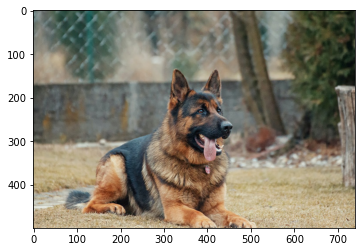

In [6]:
# Load and visualize the image
image_path = "../../data/german_shepherd_image.jpg"  # SELECT THE PATH OF YOUR IMAGE
input_image = load_image(image_path, preprocess_classification)

In [7]:
# Let's load the file containing the 1,000 labels for the ImageNet dataset classes:
with open('../../data/ImageNet_labels.txt') as f:
    labels = [line.strip() for line in f.readlines()]

In [8]:
# Load the pretrained classification model
classification_model = models.resnet18(pretrained=True)
classification_model.eval()

# Classification inference: Obtain the predictions for each category
with torch.no_grad():
    output = classification_model(input_image)

## Answer:

In [9]:
# Transform the predictions into probabilities using the softmax function
probabilities = torch.nn.functional.softmax(output, dim=1)[0] * 100

# Define the probability threshold
threshold = 80  # Choose the probability threshold value

# Print the classes whose probabilities exceed the threshold
for idx, probability in enumerate(probabilities):
    if probability > threshold:
        label = labels[idx]
        print("Class:", label)
        print("Probability:", probability.item())

Class: 235, German_shepherd
Probability: 99.70854949951172


# Exercise 3

### This part of the code is exactly the same as the provided in the example:

In [10]:
# Define the transforms: In this case, we won't crop the image
preprocess_segmentation = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )])


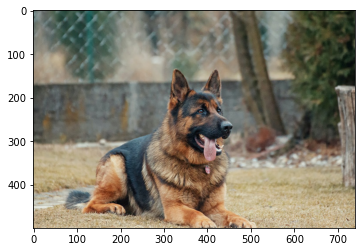

In [11]:
# Load and visualize the image
image_path = "../../data/german_shepherd_image.jpg" # SELECT THE PATH OF YOUR IMAGE
input_image = load_image(image_path, preprocess_segmentation)

In [12]:
# Load the model
segmentation_model = models.segmentation.fcn_resnet50(pretrained = True)
segmentation_model.eval()

# Segmentation inference
with torch.no_grad():
    output = segmentation_model(input_image)['out']
    output_predictions = output.argmax(1).squeeze().detach().cpu().numpy()

### Answer:

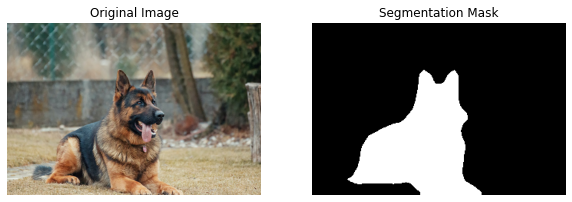

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(Image.open(image_path).convert("RGB"))
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(output_predictions, cmap='gray')
axes[1].set_title('Segmentation Mask')
axes[1].axis('off')

plt.show()

# Exercise 4

### This part of the code is exactly the same as the provided in the example:

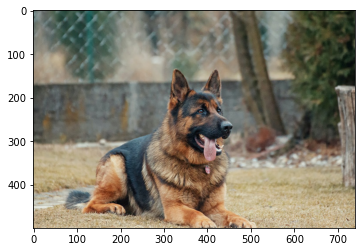

In [14]:
# Define the transforms
preprocess_detection = transforms.Compose([
    transforms.Resize((520)),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.uint8) ])

# Load and visualize the image
image_path = "../../data/german_shepherd_image.jpg" # SELECT THE PATH OF YOUR IMAGE
input_image = load_image(image_path, preprocess_detection)

In [17]:
# Load the pretrained detection model
detection_model = models.detection.maskrcnn_resnet50_fpn(pretrained = True)
detection_model.eval()

# Detection inference
batch = convert_image_dtype(input_image, dtype = torch.float)
with torch.no_grad():
    outputs = detection_model(batch)

In [18]:
# Define a function to show the image with the bounding boxes
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

### Answer:

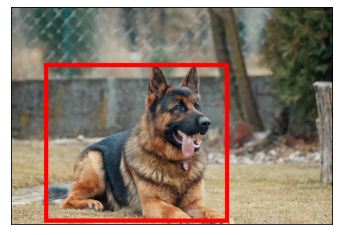

In [19]:
# We will load the original image and then proceed to draw the bounding boxes over it
original_image = Image.open(image_path).convert("RGB")
original_image = preprocess_detection(original_image)

score_threshold = .8
imagen_with_boxes = [
    draw_bounding_boxes(original_image, boxes=output['boxes'][output['scores'] > score_threshold], colors = 'red', width = 10)
    for imagen_int, output in zip(input_image, outputs)
]
show(imagen_with_boxes)